# Aligned SOM
The *TensorFlow* implementation of the [Basic SOM](https://github.com/e0526847/basic-som/blob/master/Basic%20SOM.ipynb) can be expanded to an *Aligned SOM*, as it is introduced in the paper [Aligned Self-Organizing Maps](https://pdfs.semanticscholar.org/e75a/822a0cc98ab123db7f271ae5402ef3081835.pdf) by Elias Pampalk.

<div class="alert alert-block alert-info">
Methods, variables and operations which have been introduced as part of the **Aligned SOM**, are marked with a **as_** prefix.
</div>

In [1]:
import tensorflow as tf # notebook based on tensorflow v. 1.4.0.  
import numpy as np
from random import randint

## Class SOM

The **class SOM** represents a self-organizing map, and in terms of an *aligned SOM*, it represents a single **SOM layer**. It is defined with the following parameters:    
-  **m, n**: &nbsp; dimensions of the SOM layer
-  **dim**: &nbsp; number of item features    
-  **layer**: &nbsp; number of the layer it represents (default: 0)
-  **n_iterations**: &nbsp; total number of training iterations (default: 1)
-  **alpha**: &nbsp; learning rate (default: 0.3)
-  **sigma**: &nbsp; radius of the *best matching unit* (BMU), used as the neighbourhood value (default: max(m,n)/2.0)    

A TensorFlow graph **_graph** contains the dataflow structure that is needed for the training procedure.    
The initialization of a SOM layer is as follows.

In [2]:
class SOM(object):
    def __init__(self, m, n, dim, layer=0, n_iterations=1, alpha=None, sigma=None):
        self._m = m
        self._n = n
        self._dim = dim
        if alpha is None:
            self.alpha = 0.3
        else:
            self.alpha = float(alpha)
        if sigma is None:
            self.sigma = max(m, n) / 2.0
        else:
            self.sigma = float(sigma)
        self.as_layer = layer
        self._n_iterations = abs(int(n_iterations))
        
        self._graph = tf.Graph()

## Class methods    
The **SOM** class requires some methods we will introduce one after another. 

-  **_neuron_locations**    
yields the 2-D locations of the individual neurons in the SOM layer:

In [3]:
def _neuron_locations(self,m,n):
    for i in range(m):
        for j in range(n):
            yield np.array([i,j])

-  **as_train**    
is a modified *train* method of the *Basic SOM*;    
it trains the SOM layer for one iteration (no. *iter_no*) on one item (*input_vect*)

In [4]:
def as_train(self, input_vect, iter_no):
    self._sess.run(self._training_op, feed_dict={self._vect_input: input_vect, self._iter_input: iter_no})
    self._weightages = list(self._sess.run(self._weightage_vects)) # list of weight vectors, starting with the upper left one
    self._locations = list(self._sess.run(self._location_vects)) # list of the corresponding locations [x,y]
    self._sess.run(self.as_delta_op, feed_dict={self._vect_input: input_vect, self._iter_input: iter_no}) # deltas from this training
    self._trained = True

-  **as_align**    
depending on the *decay* rate and the *delta* values obtained during the training iteration of the current layer, the method aligns all remaining layers;    
the higher *decay* the stronger is the influence of the results from the current layer

In [5]:
def as_align(self, deltas, decay):
    with self._graph.as_default():
        as_align_op = tf.assign(self._weightage_vects, tf.add(self._weightage_vects, tf.multiply(tf.convert_to_tensor(deltas), decay)))
    self._sess.run(as_align_op)

-  **map_vects**    
maps each input vector to the relevant neuron in the SOM grid

In [6]:
def map_vects(self, input_vects):
    if not self._trained:
        raise ValueError("SOM not trained yet")
 
    to_return = []
    for vect in input_vects:
        min_index = min([i for i in range(len(self._weightages))],
                            key=lambda x: np.linalg.norm(vect - self._weightages[x]))
        to_return.append(self._locations[min_index])
 
    return to_return    

-  **init_graph**    
The method **init_graph()** initializes the previously created graph with its operations and tensors;    
<font color=grey>the initialization was originally part of the class costructor. For the purposes of a step by step execution, it is split and moved here.</font>

> The following data is stored in the <font color=green>class SOM</font>:
-  **_weightage_vects**: weight vectors of the units, each of dimentionality *dim*, stored in a matrix of the size [m*n,dim]    
-  **as_deltas**: delta values from the training iteration
-  **as_p**: vector containing the layer's p-values
-  **_location_vects**: SOM grid location of the units, stored as coordinates x,y in a matrix of the size [m*n, 2]
-  **_vect_input**: training vector
-  **_iter_input**: iteration number

> The following data is calculated during the <font color=green>training</font>:    
-  **as_bmu_index**: index of the *best matching unit*, based on the Euclidean distance between the unit's weight vector and the input, includes the layer's p-values
-  **bmu_loc**: location of the *best matching unit*, based on its index
-  **learning_rate_op**: learning rate operation
-  **_alpha_op**: learning rate, decreasing with each iteration
-  **_sigma_op**: neighbourhood radius, decreasing with each iteration
-  **bmu_distance_squares** Manhattan distance from the BMU
-  **neighbourhood_func** neighbourhood operation: $e^{(-bmu\_dist/sigma)}$
<a id='init_graph'></a>

In [7]:
def init_graph(self):
    self._graph = tf.Graph()
    with self._graph.as_default(): # declare as the default graph of the current thread
        self._weightage_vects = tf.Variable(as_weights) # initial weight vectors with random values (identical for each layer)
        self.as_deltas = tf.Variable(tf.zeros([self._m*self._n,self._dim])) # delta values from the training, initialized with 0.0
        self.as_p = tf.concat([tf.tile(tf.constant([as_p1[self.as_layer]]), [as_f1]), 
                               tf.tile(tf.constant([as_p0[self.as_layer]]), [as_f2])], 0) # p-vector for this layer
        self._location_vects = tf.constant(np.array(list(self._neuron_locations(self._m, self._n)))) # SOM grid location
        self._vect_input = tf.placeholder("float", [self._dim]) # training vector
        self._iter_input = tf.placeholder("float") # iteration number
        
        # operations of the training procedure...
        # BMU index
        as_bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
                tf.pow(tf.subtract(self._weightage_vects, tf.multiply(tf.stack(
                    [self._vect_input for i in range(self._m*self._n)]), self.as_p)), 2), 1)), 0)
        
        # BMU location as [x y]
        slice_input = tf.pad(tf.reshape(as_bmu_index, [1]), np.array([[0,1]]))
        bmu_loc = tf.reshape(tf.slice(self._location_vects, slice_input,tf.constant(np.array([1, 2]))),[2])
        
        # learning rate
        learning_rate_op = tf.subtract(1.0, tf.div(self._iter_input, self._n_iterations)) # 1-(current iteration / number iterations)
        _alpha_op = tf.multiply(self.alpha, learning_rate_op) # default alpha * decreasing learning rate
        _sigma_op = tf.multiply(self.sigma, learning_rate_op) # default sigma * decreasing learning rate
        
        # neighbourhood
        bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(self._location_vects, tf.stack([bmu_loc for i in range(self._m*self._n)])), 2), 1)
        neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(bmu_distance_squares, "float32"), tf.pow(_sigma_op, 2))))
        
        # operations for the update on weight vectors
        # new weight = old weight + delta, where delta = lrm * (input vector - current weight vector)
        learning_rate_op = tf.multiply(_alpha_op, neighbourhood_func)
        learning_rate_multiplier = tf.stack([tf.tile(tf.slice(learning_rate_op, np.array([i]), np.array([1])), [self._dim]) for i in range(self._m*self._n)])
        self.weightage_delta = tf.multiply(learning_rate_multiplier,
                            tf.subtract(tf.stack([self._vect_input for i in range(self._m*self._n)]),self._weightage_vects))                                         
        new_weightages_op = tf.add(self._weightage_vects, self.weightage_delta)
        self._training_op = tf.assign(self._weightage_vects, new_weightages_op) # update weight vectors (weight vector + delta)
        self.as_delta_op = tf.assign(self.as_deltas, self.weightage_delta) # calculated delta values for the align process
                
        # session initialization
        self._sess = tf.Session()
        
        # global variable initialization
        init_op = tf.global_variables_initializer()
        self._sess.run(init_op)

In this notebook, due to a step-by-step execution, the described methods are added to each **SOM** layer retrospectively (see [example](#example_animals) below).

## General functions  
In order to coordinate and align the layers of the *aligned SOM*, some general functions are required:

-  **as_init_p**    
two distinct p-values relate to each SOM layer, indicating the influence of the particular aspects of similarity,    
where the focus is on the first aspect on the first layer, and on the second aspect on the final layer;    
for all the layers in between, the p-values are interpolated

In [8]:
# p-values
def as_init_p(l):
    # layers 0 to (<number layers>-1)
    as_layers = tf.range(0, l, delta=1, dtype=tf.float32)
    # scaling to [0,1] --> tensor with p-values corresponding to the layers in <as_layers>, starting with p=0
    as_p0 = tf.div(tf.subtract(as_layers,tf.reduce_min(as_layers)),
    tf.subtract(tf.reduce_max(as_layers),tf.reduce_min(as_layers)))
    # p0 in reversed order --> tensor with p-values corresponding to the layers in <as_layers>, starting with p=1
    as_p1 = tf.keras.backend.reverse(as_p0, 0)
    return as_p0, as_p1

-  **as_init_weights**    
initialization of weight vectors, identical for each layer

In [9]:
# initial weight vectors (identical for all layers)
def as_init_weights(m,n,dim):
    return tf.random_normal([m*n, dim])

-  **as_align_layers**    
due to mutual influence, all layers are adapted to the results of the current *layer* after its training iteration;    
the closer a layer is to the current layer the stronger it is adjusted;
*coef* describes the strength of the general influence

In [10]:
# weights adjustment between layers
def as_align_layers(layer, coef=1.0):
    if (layer.as_layer > 0):
        for i in range(0, layer.as_layer):
            decay = coef*(2**(-(layer.as_layer-i)))
            as_layers[i].as_align(layer._sess.run(layer.as_deltas), decay)
    if (layer.as_layer < as_l-1):
        for j in range(layer.as_layer+1, as_l):
            decay = coef*(2**(-(j-layer.as_layer)))
            as_layers[j].as_align(layer._sess.run(layer.as_deltas), decay)

<a id='example_animals'></a>
## Example - Animal clustering:    
The closer a layer number is to 0 the stronger it shows the aspect of the animal appearance. On the other hand, the closer a layer number is to the total number of layers the stronger it shows the aspect of the animal behaviour.    

According to the following encoding of animal features, all the birds, except for the *eagle*, have identical appearance. Hence, the first layer (layer 0) of the aligned SOM, which considers the nine appearance features foremost, should cluster them together. With an increasing layer number though, the *eagle* should close in on the *hawk* and the *owl* since they share the same behaviour.    

*owl* and *hawk* are encoded as having identical appearance as well as identical behaviour. Hence we should see the two of them close together on each of the layers. The same goes for *horse* and *zebra*.

Please keep in mind that the layers influence each other. With each iteration, a random layer is trained on a random animal, so depending on the order of trained layers and the particular animal, the final clustering can turn out slightly different each time. 

The SOM mapping of the animals can be found at the end of the following code cell. The test includes five layers and 200 training iterations.

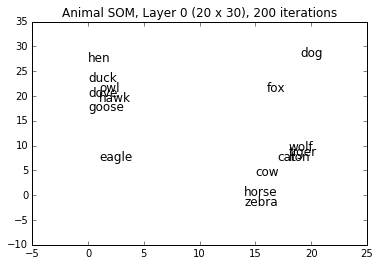

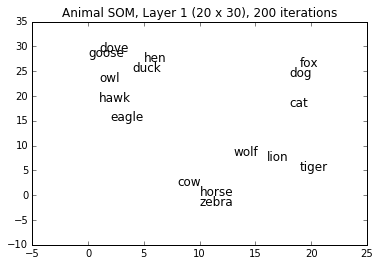

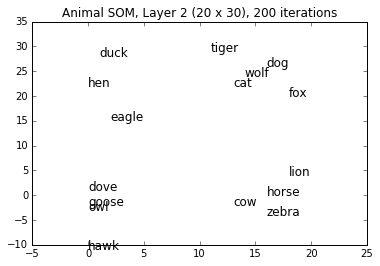

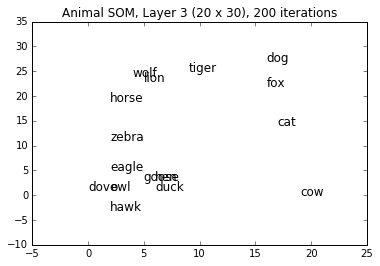

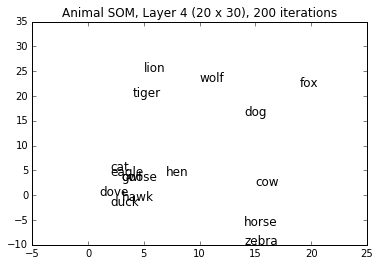

In [11]:
import types # for the retrospective inclusion of methods to a class instance
from matplotlib import pyplot as plt # for plotting the images
%matplotlib inline

# one-hot encoding of animal features
# the first 9 values belong to the view aspect of appearance, followed by the animal's behaviour
animals = np.array(
     [[1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.], # dove
      [1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.], # hen
      [1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.], # duck
      [1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.], # goose
      [1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.], # owl
      [1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.], # hawk
      [0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.], # eagle
      [0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.], # fox
      [0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.], # dog
      [0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.], # wolf
      [1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.], # cat
      [0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.], # tiger
      [0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.], # lion
      [0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0.], # horse
      [0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0.], # zebra
      [0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.]])# cow
animals_names = \
    ['dove', 'hen', 'duck', 'goose', 'owl', 'hawk', 'eagle', 'fox', 
     'dog', 'wolf', 'cat', 'tiger', 'lion', 'horse', 'zebra', 'cow']

main_sess = tf.Session()
as_l = 5 # number of layers
as_m = 20 # layer width
as_n = 30 # layer height
as_dim = 13 # item dimentionality (features)
as_f1 = 9 # number features of aspect 1 (appearance)
as_f2 = as_dim - as_f1 # number features of aspect 2 (activity)
as_iter = 200 # number of iterations
as_infl = 1.0 # intensity of mutual influence between layers
as_layers = [] # layers of the aligned SOM
as_mapped = [] # item mapping to neurons

# init p values
as_p0, as_p1 = main_sess.run(as_init_p(as_l))
# init weight vectors (identical for all layers)
as_weights = main_sess.run(as_init_weights(as_m,as_n,as_dim))

export = False # if True, files with the trained SOM weight vectors will be written in SOMToolbox format to <exportPath>
exportPath = 'exports/' # path to the export files, ie. 'exports/'

# init layers
for i in range(as_l):
    as_layers.append(SOM(as_m, as_n, as_dim, i, as_iter))
    # add class methods to the SOM objects/layers
    as_layers[i]._neuron_locations = types.MethodType(_neuron_locations,as_layers[i])
    as_layers[i].as_train = types.MethodType(as_train,as_layers[i])
    as_layers[i].as_align = types.MethodType(as_align,as_layers[i])
    as_layers[i].map_vects = types.MethodType(map_vects,as_layers[i])
    as_layers[i].init_graph = types.MethodType(init_graph,as_layers[i])
    as_layers[i].init_graph()

#------------------------ main training procedure
for i in range(as_iter):
    as_next_layer = randint(0, as_l-1) # select a random layer
    as_next_item = randint(0,len(animals)-1) # select a random item
    # train current layer on current item
    as_layers[as_next_layer].as_train(animals[as_next_item],i)
    # align remaining layers
    as_align_layers(as_layers[as_next_layer], as_infl)
 
# map animals to their closest neurons
for i in range(as_l):
    as_mapped.append(as_layers[i].map_vects(animals))

#------------------------ export data (trained weight vectors)
if (export==True):
    for l in range(0, as_l):
        with open(str(exportPath)+"layer_"+str(l)+'_weights.wgt', "w") as f:
            f.write("#SOM Weight Vector File\r")
            f.write("#Aligned SOM - Layer " + str(l)+"\r")
            f.write("$TYPE rect\r")
            f.write("$XDIM " +str(as_m)+ "\r")
            f.write("$YDIM " +str(as_n)+ "\r")
            f.write("$VEC_DIM " +str(as_dim)+ "\r")
            weight_array = as_layers[l]._sess.run(as_layers[l]._weightage_vects)
            weight_array = weight_array.reshape(as_n, as_m, as_dim)
            for n in range (as_n):
                for m in range(as_m):
                    for d in range(as_dim):
                        f.write(str(weight_array[n,m,d])+' ')
                    f.write("SOM_layer_"+str(l)+"_"+str(n)+"/"+str(m)+"\r")

#------------------------ plots
as_plots = [0,1,2,3,4] # layers to be plotted

for i in as_plots:
    plt.axis([-5, as_m+5, -10, as_n+5])
    taken_cells = []
    plt.title('Animal SOM, Layer ' + str(i) + ' (' + str(as_layers[i]._m) + ' x ' + str(as_layers[i]._n) + '), ' + str(as_iter) + ' iterations')
    for i, m in enumerate(as_mapped[i]):
        for c in taken_cells:
            if (c==m).any():
                m[1] = m[1]-2
        taken_cells.append(m
                          )
        plt.text(m[0], m[1], animals_names[i], fontsize=12)
    plt.show()

main_sess.close()

If the SOM visualizations have not been displayed inline (GitHub), you can find the solutions from my local training below:

![SOM Layer 0](pics/layer_0_20x30_2000.png)
![SOM Layer 1](pics/layer_1_20x30_2000.png)
![SOM Layer 2](pics/layer_2_20x30_2000.png)
![SOM Layer 3](pics/layer_3_20x30_2000.png)
![SOM Layer 4](pics/layer_4_20x30_2000.png)